## 모듈 설치

In [3]:
import tensorflow as tf
from tqdm.notebook import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

# 데이터 다운로드

In [4]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2017.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2017/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

## 경로 지정

In [5]:
train_PATH="/home/seeds/iconms12/tmp/tf_image_captioning/train2017/"
test_PATH="/home/seeds/iconms12/tmp/tf_image_captioning/test2017/"
train_annotation_file = "/home/seeds/iconms12/tmp/tf_image_captioning/annotations/captions_train2017.json"
test_annotation_file = "/home/seeds/iconms12/tmp/tf_image_captioning/annotations/captions_val2017.json"
image_folder = '/train2017/'

In [6]:
with open(train_annotation_file, 'r') as f:
    annotations = json.load(f)

In [7]:
image_path_to_caption = collections.defaultdict(list) #다운로드 받은 이미지_캡션 데이터
for val in annotations['annotations']:
    image_path = train_PATH + '%012d.jpg' % (val['image_id'])
    caption = f"<start> {val['caption']} <end>"
    image_path_to_caption[image_path].append(caption)
    
    
f=open('rf1.txt', 'r') #추가 이미지 및 캡션 데이터
for line in f:
    a=line.split(",")
    image_path=train_PATH + a[0]
    caption=f"<start> {a[1]} <end>"
    caption=caption.replace("\n"," ")
    image_path_to_caption[image_path].append(caption)

In [8]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths) #이미지 섞기

train_image_paths = image_paths
print(len(train_image_paths)) #총 이미지의 개수

118344


In [12]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]  #이미지의 캡션 5개 변수할당
  train_captions.extend(caption_list) #1차원 벡터로 이미지 캡션 5개씩 확장
  img_name_vector.extend([image_path] * len(caption_list)) #이미지 이름이 캡션에 매칭될수있도록 5배씩 확장하여 1차원 벡터에 할당

In [13]:
with open('train_captions.pkl', 'wb') as f: #만들어진 데이터셋 pickel로 저장
    pickle.dump(train_captions, f)

<start> A lamp in a room next to a bed near a window. <end>


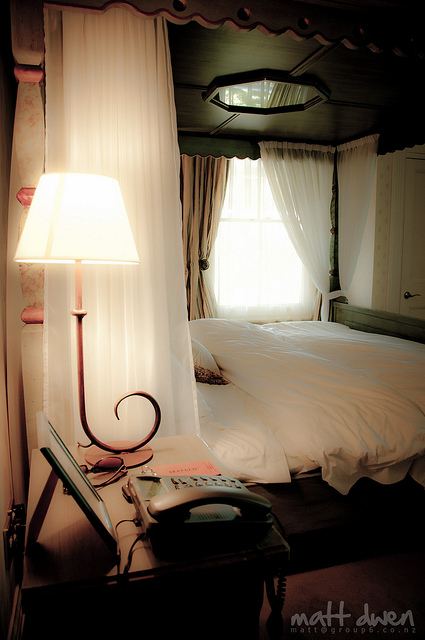

In [14]:
print(train_captions[0])
Image.open(img_name_vector[0])

## 이미지 불러오기 (전처리)

In [15]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## IncceptionV3를 사용하여 사전학습된 image Net의 가중치를 가져와 학습

In [16]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
#299,299,3 의 데이터를 
#(64,2048)의 크기의 텐서로 변환

## 이미지 데이터 처리 Inception_V3를 이용

In [17]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset): #이미지 데이터
  batch_features = image_features_extract_model(img) #각 특징값을 잡아서 추출
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8") #바이너리화 되있는 경로를 decoding후 할당
    np.save(path_of_feature, bf.numpy()) #추출된 데이터들을 저장시킴

A Jupyter Widget

## 토크나이저를 사용한 캡션 데이터 전처리 과정

In [18]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor) 
#가장 길이가 큰 문장에 맞춰 pad를 할당할수있게끔 가장길이가 긴 문장을 찾는 함수

In [19]:

top_k = 10000  #15000개의 단어만을 vocab에서 사용하게끔 함
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions) #문장을 토크나이저를 통하여 학습후
train_seqs = tokenizer.texts_to_sequences(train_captions) #학습된 토크나이저가 문장 리스트를 seqs형태로 저장시킴


In [20]:
tokenizer.word_index['<pad>'] = 0 #문장의 길이를 맞추는 PAD를 idx 0에 저장
tokenizer.index_word[0] = '<pad>'

In [21]:
train_seqs = tokenizer.texts_to_sequences(train_captions)  #토크나이저 벡터 생성

In [22]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') #pad를 앞에서 부터저장

# 각 벡터를 캡션의 max_length까지 채 웁니다.
# max_length 값을 제공하지 않으면 pad_sequences가 자동으로 계산합니다.

In [23]:
max_length = calc_max_length(train_seqs) 
#가중치를 저장하는 데 사용되는 max_length를 계산합니다.

In [24]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f) #토크나이저 추출

## 훈련셋과 테스트셋 나눔

In [25]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)


img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8) #훈련셋 80% 테스트셋 20%
img_name_train_keys, img_name_val_keys = img_keys[:slice_index] , img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [26]:
BATCH_SIZE = 256 #한번에 네트워크에 넘겨주는 데이터의 수 64개
BUFFER_SIZE = 1000 #고정된 버퍼를 사용하여 항목이 통과할때 순서를 섞는다.
embedding_dim = 256 #임베딩 차원
units = 512 #노드 개수는 512개
vocab_size = top_k + 1 #사전크기 50000개 
num_steps = len(img_name_train) // BATCH_SIZE # 4000 // 64 만큼의 스탭을 반복하여 1epoch의 학습을 진행함
v_num_steps = len(img_name_val) // BATCH_SIZE

#InceptionV3에서 추출한 벡터의 모양은 (64, 2048)
features_shape = 2048 #특징 크기
attention_features_shape = 64 #주의 해야할 특징 크기

In [27]:
# 위에서 저장해둔 특징값 넘파이를 불러와 저장
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
#dataset의 첫번째 값은 img_tensor(특징값),두번째는 caption

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

v_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))


v_dataset = v_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# 섞고 배치하기
v_dataset = v_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
v_dataset = v_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [29]:
len(v_dataset)

463

## 모델

In [30]:
class BahdanauAttention(tf.keras.Model): #디코더가 스스로 어떤 벡터에 중점을 둬서 정보를 취할지 선택
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) #은닉층 출력뉴런 512
    self.W2 = tf.keras.layers.Dense(units) #은닉층 출력뉴런 512
    self.V = tf.keras.layers.Dense(1) #출력층 출력 뉴런 1

  def call(self, features, hidden):
    #score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
    #attention_hidden_layer=(256,64,512)

    score = self.V(attention_hidden_layer) #출력층에서 나오는값

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [31]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim) #256,64,256

    def call(self, x):
        x = self.fc(x) #함수호출시 입력값을 fc를  통해 출력한뒤 
        x = tf.nn.relu(x) #출력값이 0보다 작으면 0으로 0보다크다면 그대로 출력하는 활성화 함수를 통해
        return x #반환한다.

In [32]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #vocab size= 15001개 pad포함
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') #gru와 LSTM의 성능은 유사하나 속도면에서 차이가큼
    #512
    self.fc1 = tf.keras.layers.Dense(self.units) #512
    self.fc2 = tf.keras.layers.Dense(vocab_size) #15001

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # 어텐션을 별도의 모델로 정의 
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x) #15001개의 단어를 256개의 텐서로 임베딩

    # x shape (256, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x) #sequences와 state반환

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output) #워드 sequence를 입력하여 x로 반환

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2])) #x의 형태 변환

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x) #반환

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units)) #초기화시 (1,512)의 텐서로 반환

In [33]:
encoder = CNN_Encoder(embedding_dim) #256 임베딩
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 세이브

In [35]:

checkpoint_path = "./checkpoints/final_model1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

## 로드

In [36]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [37]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
v_loss_plot = []

In [38]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [39]:
def loss_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

    total_loss = (loss / int(target.shape[1]))
    return loss, total_loss

In [40]:
import spacy
from tqdm.notebook import tqdm
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def l1_normalize(v): #각 벡터안의 요소값을 모두 더한 것의 크기가 1이 되도록 벡터의 크기를 조절하는 방법
    norm = np.sum(v)
    return v / norm
    
    
def print_caption(): 
    cosin_list=[]
    euclidean_list=[]
    manhattan_list=[]
    ref1=[]
    ref=[]
    hyp=[]
    for j in tqdm(range(len(img_name_val))):
        image = img_name_val[j]
        t=[tokenizer.index_word[i] for i in cap_val[j] if i not in [0]]
        real_caption = t[1:-1]
        ref.append(' '.join(real_caption))

        if (j+1)% 5 == 0 :
            result, attention_plot = evaluate(image)
            hyp.append(' '.join(result[:-1]))
            ref1.append(ref)
            ref=[]
            
    a=bleuscore(ref1,hyp)
    for count,j in tqdm(enumerate(ref1)):
        matrix=j
        matrix.append(hyp[count])
        matrix=np.array(matrix)
        tfidf_matrix=vectorizer(matrix) #5개의 캡셔닝 정답문장

        tfidf_norm_l1 = l1_normalize(tfidf_matrix) # L1 정규화  
        yr=tfidf_norm_l1[0:5]
        for i in yr:
            cosin=float(cosine_similarity(tfidf_norm_l1[5], i))
            euclidean=float(euclidean_distances(tfidf_norm_l1[5], i))
            manhattan=float(manhattan_distances(tfidf_norm_l1[5], i))
            cosin_list.append(cosin)
            euclidean_list.append(euclidean)
            manhattan_list.append(manhattan)
        #return_Dict={"1_gram_bleu":a[0],"2_gram_bleu":a[1],"3_gram_bleu":a[2],"4_gram_bleu":a[3],"1~3_gram_bleu":a[4],"Jaccard":Jaccard,
         #            "cosin":np.mean(cosin_list),"euclidean":np.mean(euclidean_list),"manhattan":np.mean(manhattan_list)}
    a.append(np.mean(cosin_list))
    a.append(np.mean(euclidean_list))
    a.append(np.mean(manhattan_list))
    
    print(a)
    return a

def vectorizer(a):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(a)
    return tfidf_matrix

def bleuscore(ref,hyp):
    spacy_eng = spacy.load("en")
    jaccard=[]
    gram1_mean=[]
    gram2_mean=[]
    gram3_mean=[]
    gram4_mean=[]
    gram_13_mean=[]
    count=0
    smoothie = SmoothingFunction().method5
    for count,a in tqdm(enumerate(ref)):
        result1=hyp[count] 
        c=[]
        for i in a:
            b=[tok.text.lower() for tok in spacy_eng.tokenizer(i)]
            c.append(b)
        result=[tok.text.lower() for tok in spacy_eng.tokenizer(result1)]
        bleu_1gram = sentence_bleu(c,result, weights=(1, 0, 0, 0))
        bleu_2gram = sentence_bleu(c,result, weights=(0, 1, 0, 0),smoothing_function=smoothie)
        bleu_3gram = sentence_bleu(c,result, weights=(0, 0, 1, 0),smoothing_function=smoothie)
        bleu_4gram = sentence_bleu(c,result, weights=(0, 0, 0, 1),smoothing_function=smoothie)
        bleu_cum1 = sentence_bleu(c, result, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie)

        if(count==399):
            print(c)
            print(result)
        gram1_mean.append(bleu_1gram)
        gram2_mean.append(bleu_2gram)
        gram3_mean.append(bleu_3gram)
        gram4_mean.append(bleu_4gram)
        gram_13_mean.append(bleu_cum1)
        count+=1
        m=0
        for i in c: #자카드 유사도
            union = set(i).union(set(result))
            intersection = set(i).intersection(set(result)) 
            Jaccard= len(intersection)/len(union)
            if(m<Jaccard): #가장 유사도가 높은 문장끼리 매칭을 시켜 유사율을 반환
                m=Jaccard
        jaccard.append(m)
                    
    a=[np.mean(gram1_mean),np.mean(gram2_mean),np.mean(gram3_mean),np.mean(gram4_mean),np.mean(gram_13_mean),np.mean(jaccard)]
    
    
    return a

In [41]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) #CNN에 넣기전 특징값 모양변경

    features = encoder(img_tensor_val)  #Inception_V3로 추출된 특징값은 CNN돌림

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) #텐서 확장
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) #decoder를 통해 결과 반환

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy() #관심을 가져야되는 항목을 추출하는곳 #그래프로 출력

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() 
        result.append(tokenizer.index_word[predicted_id]) #반환값에 계속하여 해당 관심구역에대한 단어 추가

        if tokenizer.index_word[predicted_id] == '<end>': #만약 관심구역에서 나온 단어가 end라면
            return result, attention_plot #문장과 플롯을 반환

        dec_input = tf.expand_dims([predicted_id], 0) #아니라면 관심지역을 다음으로 넘겨서 문장의 길이가 최대를 넘지않을때까지 진행

    attention_plot = attention_plot[:len(result), :] #문장의 길이만큼만 그래프 그릴것
    return result, attention_plot #반환

In [42]:
 def plot_attention(image, result, attention_plot): #그래프를 그림
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

0


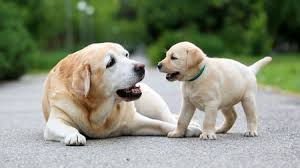

Prediction Caption: a happy dogs are at a red and white barstools


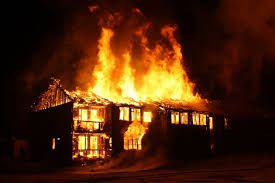

Prediction Caption: an old fire workspace out on the ground in a large mountain side and mountain in a unplugged lit country hugging


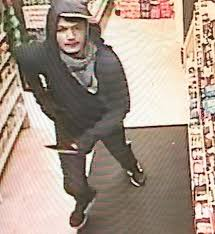

Prediction Caption: old style and plaid t v before holding


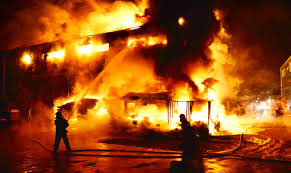

Prediction Caption: a very large fire workspace tofu


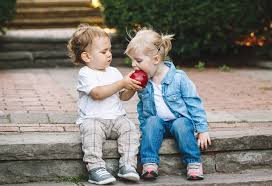

Prediction Caption: a couple of kids sitting on the steps with a birthday


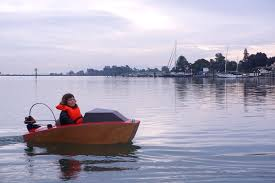

Prediction Caption: a boat with truck with of boats in the background
Train_loss
Epoch 1 Batch 0 Loss 0.4564
Epoch 1 Batch 100 Loss 0.5574
Epoch 1 Batch 200 Loss 0.5643
Epoch 1 Batch 300 Loss 0.5191
Epoch 1 Batch 400 Loss 0.5934
Epoch 1 Batch 500 Loss 0.5878
Epoch 1 Batch 600 Loss 0.5882
Epoch 1 Batch 700 Loss 0.5882
Epoch 1 Batch 800 Loss 0.5786
Epoch 1 Batch 900 Loss 0.5467
Epoch 1 Batch 1000 Loss 0.6070
Epoch 1 Batch 1100 Loss 0.5787
Epoch 1 Batch 1200 Loss 0.5819
Epoch 1 Batch 1300 Loss 0.5677
Epoch 1 Batch 1400 Loss 0.5744
Epoch 1 Batch 1500 Loss 0.5529
Epoch 1 Batch 1600 Loss 0.5818
Epoch 1 Batch 1700 Loss 0.5498
Epoch 1 Batch 1800 Loss 0.5981
Epoch 1 Loss 0.570163
Time taken for 1 epoch 664.3438057899475 sec

Validation loss
Epoch 1 Batch 0 Loss 1.7746
Epoch 1 Batch 100 Loss 1.7485
Epoch 1 Batch 200 Loss 1.8069
Epoch 1 Batch 300 Loss 1.7658
Epoch 1 Batch 400 Loss 1.7912
Epoch 1 Loss 4.047020
Time taken for 1 epoch 954.4180910587311 sec



A Jupyter Widget

In [ ]:
from IPython.display import Image as imga
import pandas as pd
start_epoch=0
EPOCHS = 10
a1=[]
a2=[]
a3=[]
a4=[]
mean_gram=[]
low=[]
high=[]
jaccard=[]
cosin=[]
euclidean=[]
manhattan=[]

def print_examples():
    path = "/home/seeds/iconms12/tmp/Image_cap/Test_img/"
    img_file = os.listdir(path)
    img_names = [file for file in img_file if file.endswith(".jpg")]
    
    for i in img_names:
        image=path+i
        display(imga(filename=image, width=300,height=200))
        result, attention_plot = evaluate(image)
        print ('Prediction Caption:', ' '.join(result[:-1]))
        
for epoch in range(start_epoch, EPOCHS):
    
    
    print(epoch)
    print_examples()
    
    start = time.time()
    total_loss = 0
    print("Train_loss")
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(float(total_loss / num_steps))
    
    ckpt_manager.save() #2epoch마다 체크포인트 저장

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
      #val
    print("Validation loss")
    for (batch, (img_tensor, target)) in enumerate(v_dataset):
        batch_loss, t_loss = loss_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    v_loss_plot.append(float(total_loss / v_num_steps))

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/v_num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    h=print_caption()
    a1.append(f'{h[0]:.3f}')
    a2.append(f'{h[1]:.3f}')
    a3.append(f'{h[2]:.3f}')
    a4.append(f'{h[3]:.3f}')
    mean_gram.append(f'{h[4]:.3f}')
    jaccard.append(f'{h[5]:.3f}')
    cosin.append(f'{h[6]:.3f}')
    euclidean.append(f'{h[7]:.3f}')
    manhattan.append(f'{h[8]:.3f}')
    

dic={'epoch':range(1, EPOCHS+1),'val_loss':v_loss_plot,'train_loss':loss_plot,'1-gram' : a1,'2-gram' : a2,'3-gram' : a3,'4-gram' : a4,
'1-3 gram' : mean_gram, "jaccard":jaccard, "cosin":cosin, "manhattan":manhattan, "euclidean":euclidean}
#dic={'train_loss':loss_plot}
#dic={'epoch':range(1, EPOCHS+1),'val_loss':v_loss_plot,'train_loss':loss_plot}
b=pd.DataFrame(dic)
b.to_csv("final_model_trained.csv", mode='w', header=True)